In [1]:
import numpy as np
import matplotlib.pyplot as plt

Get MNIST data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

X, y = mnist.data, mnist.target

In [3]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

### Build model

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

In [6]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)

param_dist = {
    "n_estimators": range(75, 275),
    "max_depth": range(20, 150),
}

rf_random_search = RandomizedSearchCV(rf_clf, param_dist, cv=3, n_iter=10)

rf_random_search = rf_random_search.fit(X_train[:10000], y_train[:10000])

In [7]:
rf_random_search.best_params_, rf_random_search.best_score_

({'n_estimators': 264, 'max_depth': 64}, np.float64(0.9463997989481011))

Train the best model with all train set

In [8]:
rf_best_model = rf_random_search.best_estimator_

rf_best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=64, n_estimators=264, n_jobs=-1,
                       random_state=42)

### Evaluate the model

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
y_pred = rf_best_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.9714

### Save the model & load it

In [11]:
import joblib

In [ ]:
joblib.dump(rf_best_model, "./models/rf_clf.joblib")

['./models/rf_clf.joblib']

Evalute loaded model

In [ ]:
model_loaded = joblib.load("./models/rf_clf.joblib")

y_load_model_pred = model_loaded.predict(X_test)

accuracy_score(y_test, y_load_model_pred)

0.9718

### Build blur setting model
This model for set the best hyperparemters of blur function (blur/bold) to make the digit to look like MNIST dataset.

I will use `canvases.csv` file, contain digit I created it manually on Pygame.

In [12]:
import csv

canvases = []

with open("./canvases.csv", 'r', newline='') as csvfile:
    # Create a CSV reader object
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        canvases.append(
            [np.int16(row[:-1]), np.int32(row[-1])]
        )

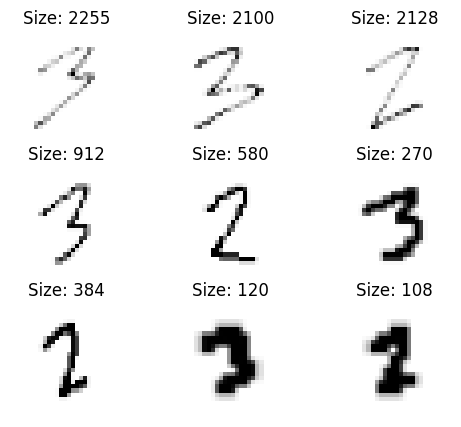

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(6, 5))

for i in range(len(canvases)):
    canvas, size = canvases[i]
    ax = axes[i//3][i%3]
    ax.set_title(f"Size: {size}")
    ax.imshow(
        canvas.reshape(28, 28), cmap="Grays"
    )
    ax.axis("off")

As you can see some digits are too thin, and others are too bold, this will make model predict wrong.

The next code set a the best hyperparameters manually, to make the digit look a same until if these has different sizes

In [14]:
from skimage.transform import resize

# This a same that are in `prediction.py` file
def blur_digit(digit, blur=0.5, bold=2):
    shape = int(np.sqrt(len(digit))) if len(digit.shape) == 1 else len(digit)
    digit = digit.reshape((shape,) * 2)
    digit_blured = resize(resize(digit, [round(28 * blur)] * 2, preserve_range=True), (28, 28), preserve_range=True)
    digit_blured = digit_blured * bold
    digit_blured[digit_blured > 255] = 255
    return digit_blured

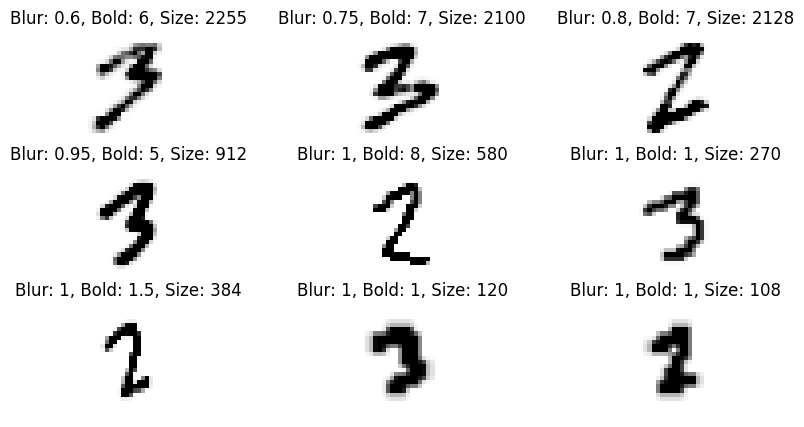

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(10, 5))

settings = [
    (0.6, 6), (0.75, 7), (0.8, 7),
    (0.95, 5), (1, 8), (1, 1),
    (1, 1.5), (1, 1), (1, 1),
]
sizes = []

for i in range(len(canvases)):
    canvas, size = canvases[i]
    sizes.append(size)

    setting = settings[i]
    
    ax = axes[i//3][i%3]
    ax.set_title(f"Blur: {setting[0]}, Bold: {setting[1]}, Size: {size}")
    ax.imshow(
        blur_digit(canvas, *setting), cmap="Grays"
    )
    ax.axis("off")

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

sett_reg = make_pipeline(PolynomialFeatures(2), LinearRegression())

X = np.reshape(np.int32(sizes), (-1, 1))

sett_reg.fit(X, settings)

joblib.dump(sett_reg, "./models/scale_setting_reg.joblib")

['./models/scale_setting_reg.joblib']

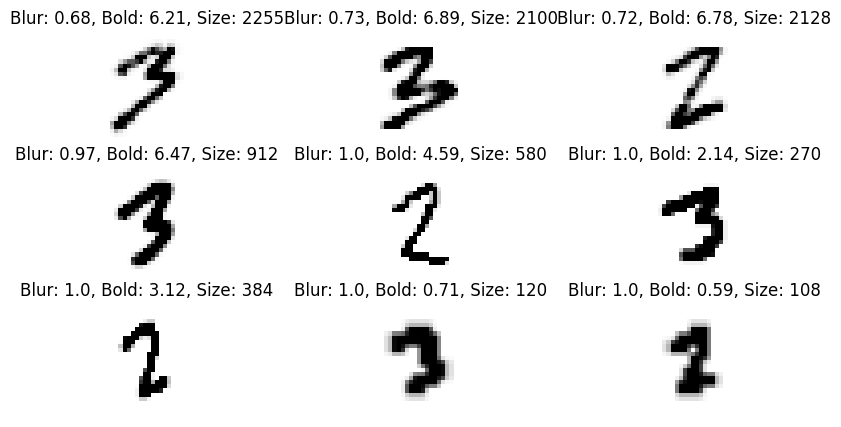

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(10, 5))

for i in range(len(canvases)):
    canvas, size = canvases[i]

    setting = sett_reg.predict([[size]])[0]
    
    ax = axes[i//3][i%3]
    ax.set_title(f"Blur: {setting[0].round(2)}, Bold: {setting[1].round(2)}, Size: {size}")
    ax.imshow(
        blur_digit(canvas, *setting), cmap="Grays"
    )
    ax.axis("off")